# How to reproduce (and play) with `neos`:

We first need to install a special branch of `pyhf`:

In [1]:
%pip install git+http://github.com/scikit-hep/pyhf.git@make_difffable_model_ctor

  Cloning http://github.com/scikit-hep/pyhf.git (to revision make_difffable_model_ctor) to /tmp/pip-req-build-ol32u9ie
  Running command git clone --filter=blob:none --quiet http://github.com/scikit-hep/pyhf.git /tmp/pip-req-build-ol32u9ie
  Running command git checkout -b make_difffable_model_ctor --track origin/make_difffable_model_ctor
^C
ERROR: Operation cancelled by user
Note: you may need to restart the kernel to use updated packages.


Start with a couple of imports:

In [1]:
from jax.example_libraries import stax  # neural network library for JAX
from jax.random import PRNGKey  # random number generator
import jax.numpy as jnp  # JAX's numpy
import neos  # :)

`neos` experiments have been designed to run through a flexible `Pipeline` class, which will compose the necessary ingredients to train differentiable analyses end-to-end.

We have other examples in the works, but for now, we have wrapped up our current experiments in a module called `nn_observable`:

In [2]:
from neos.experiments.nn_observable import (
    nn_summary_stat,  # create a summary statistic from a neural network
    make_model,  # use the summary statistic to make a HistFactory style model
    generate_data,  # generates gaussian blobs to feed into the nn
    first_epoch,  # special plotting callback for the first epoch
    last_epoch,  # special plotting callback for the last epoch
    per_epoch,  # generic plotting callback for each epoch
    plot_setup,  # inital setup for the plotting
)

Each of these functions are pretty lightweight (with the exception of the plotting) -- if you want to get experimental and write your own pipeline, you'll find the code for those functions as a good starting point!

Now we'll jump into training! First, we set up a neural network (for regression) and a random state:

In [3]:
rng_state = 0  # random state

# feel free to modify :)
init_random_params, nn = stax.serial(
    stax.Dense(1024),
    stax.Relu,
    stax.Dense(1024),
    stax.Relu,
    stax.Dense(1),
    stax.Sigmoid,
)

_, init_pars = init_random_params(PRNGKey(rng_state), (-1, 2))

From there, we compose our pipeline with the relevant ingredients. I'll point out things you can play with immediately:

In [4]:
p = neos.Pipeline(
    data=generate_data(rng=rng_state, num_points=10000),  # total number of points
    yield_kwargs=dict(
        bandwidth=1e-1,  # bandwidth of the KDE (lower = more like a real histogram)
        bins=jnp.linspace(0, 1, 5),  # binning of the summary stat (over [0,1])
    ),
    nn=nn,  # the nn we defined above
    loss=lambda x: x[
        "CLs"  # our chosen loss metric!
    ],  # you can compose your own loss from a dict of metrics (see p.possible_metrics)
    num_epochs=5,  # number of epochs
    batch_size=2000,  # number of points per batch
    plot_name="demo_nn_observable.png",  # save the final plot!
    animate=True,  # make cool animations!
    animation_name="demo_nn_observable.gif",  # save them!
    random_state=rng_state,
    yields_from_pars=nn_summary_stat,
    model_from_yields=make_model,
    init_pars=init_pars,
    first_epoch_callback=first_epoch,
    last_epoch_callback=last_epoch,
    per_epoch_callback=per_epoch,
    plot_setup=plot_setup,
)

Then we run! Each epoch takes around 15s on my local CPU, so expect something similar :)

You'll see some cool plots and animations, so it's worth it ;)

epoch 4/5: 4 batches
batch 4/4 took 5.0345s.

batch loss: 9.36e-06
metrics evaluated on test set:
yields:
  s = [1.84, 2.31, 5.04, 10.8]
  b = [90.3, 6.25, 3, 0.4]
  bup = [72.4, 13.1, 9.3, 5.15]
  bdown = [72, 14.5, 9.85, 3.75]
CLs = 1.05e-06
mu_uncert = 0.0795
pull_width = 0.906
1-pull_width**2 = 0.00877
pull = -0.00898
loss = 1.05e-06



(<matplotlib.animation.ArtistAnimation at 0x7f1f8c603c70>,
 {'CLs': [DeviceArray(2.35287632e-05, dtype=float64),
   DeviceArray(1.70566834e-06, dtype=float64),
   DeviceArray(1.11617354e-06, dtype=float64),
   DeviceArray(1.08438735e-06, dtype=float64),
   DeviceArray(1.97689571e-06, dtype=float64),
   DeviceArray(3.39126491e-06, dtype=float64),
   DeviceArray(3.25749298e-06, dtype=float64),
   DeviceArray(3.22669855e-06, dtype=float64),
   DeviceArray(3.14261578e-06, dtype=float64),
   DeviceArray(3.12066055e-06, dtype=float64),
   DeviceArray(2.90500077e-06, dtype=float64),
   DeviceArray(2.84339593e-06, dtype=float64),
   DeviceArray(2.31737151e-06, dtype=float64),
   DeviceArray(1.39411512e-06, dtype=float64),
   DeviceArray(1.07047366e-06, dtype=float64),
   DeviceArray(9.87367532e-07, dtype=float64),
   DeviceArray(9.80170437e-07, dtype=float64),
   DeviceArray(9.47542831e-07, dtype=float64),
   DeviceArray(1.07959525e-06, dtype=float64),
   DeviceArray(1.04620676e-06, dtype=floa

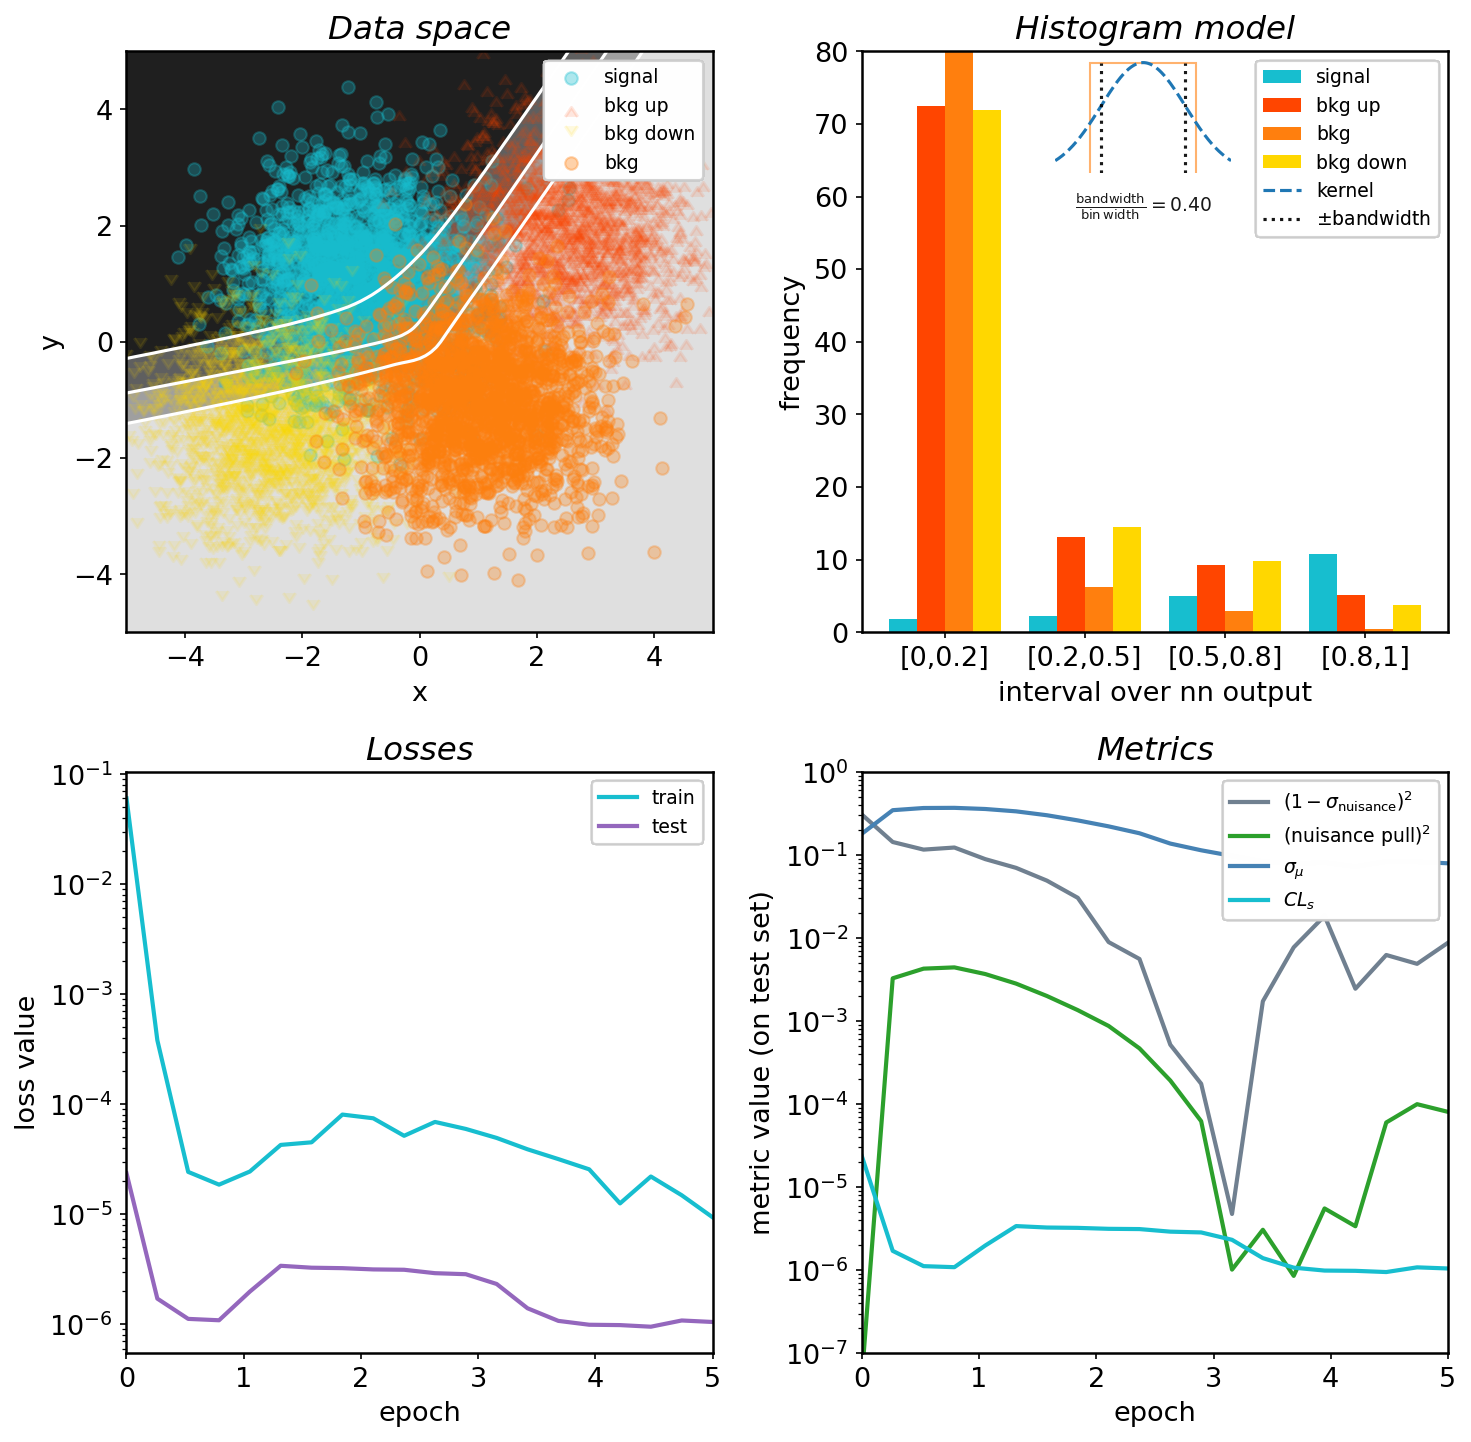

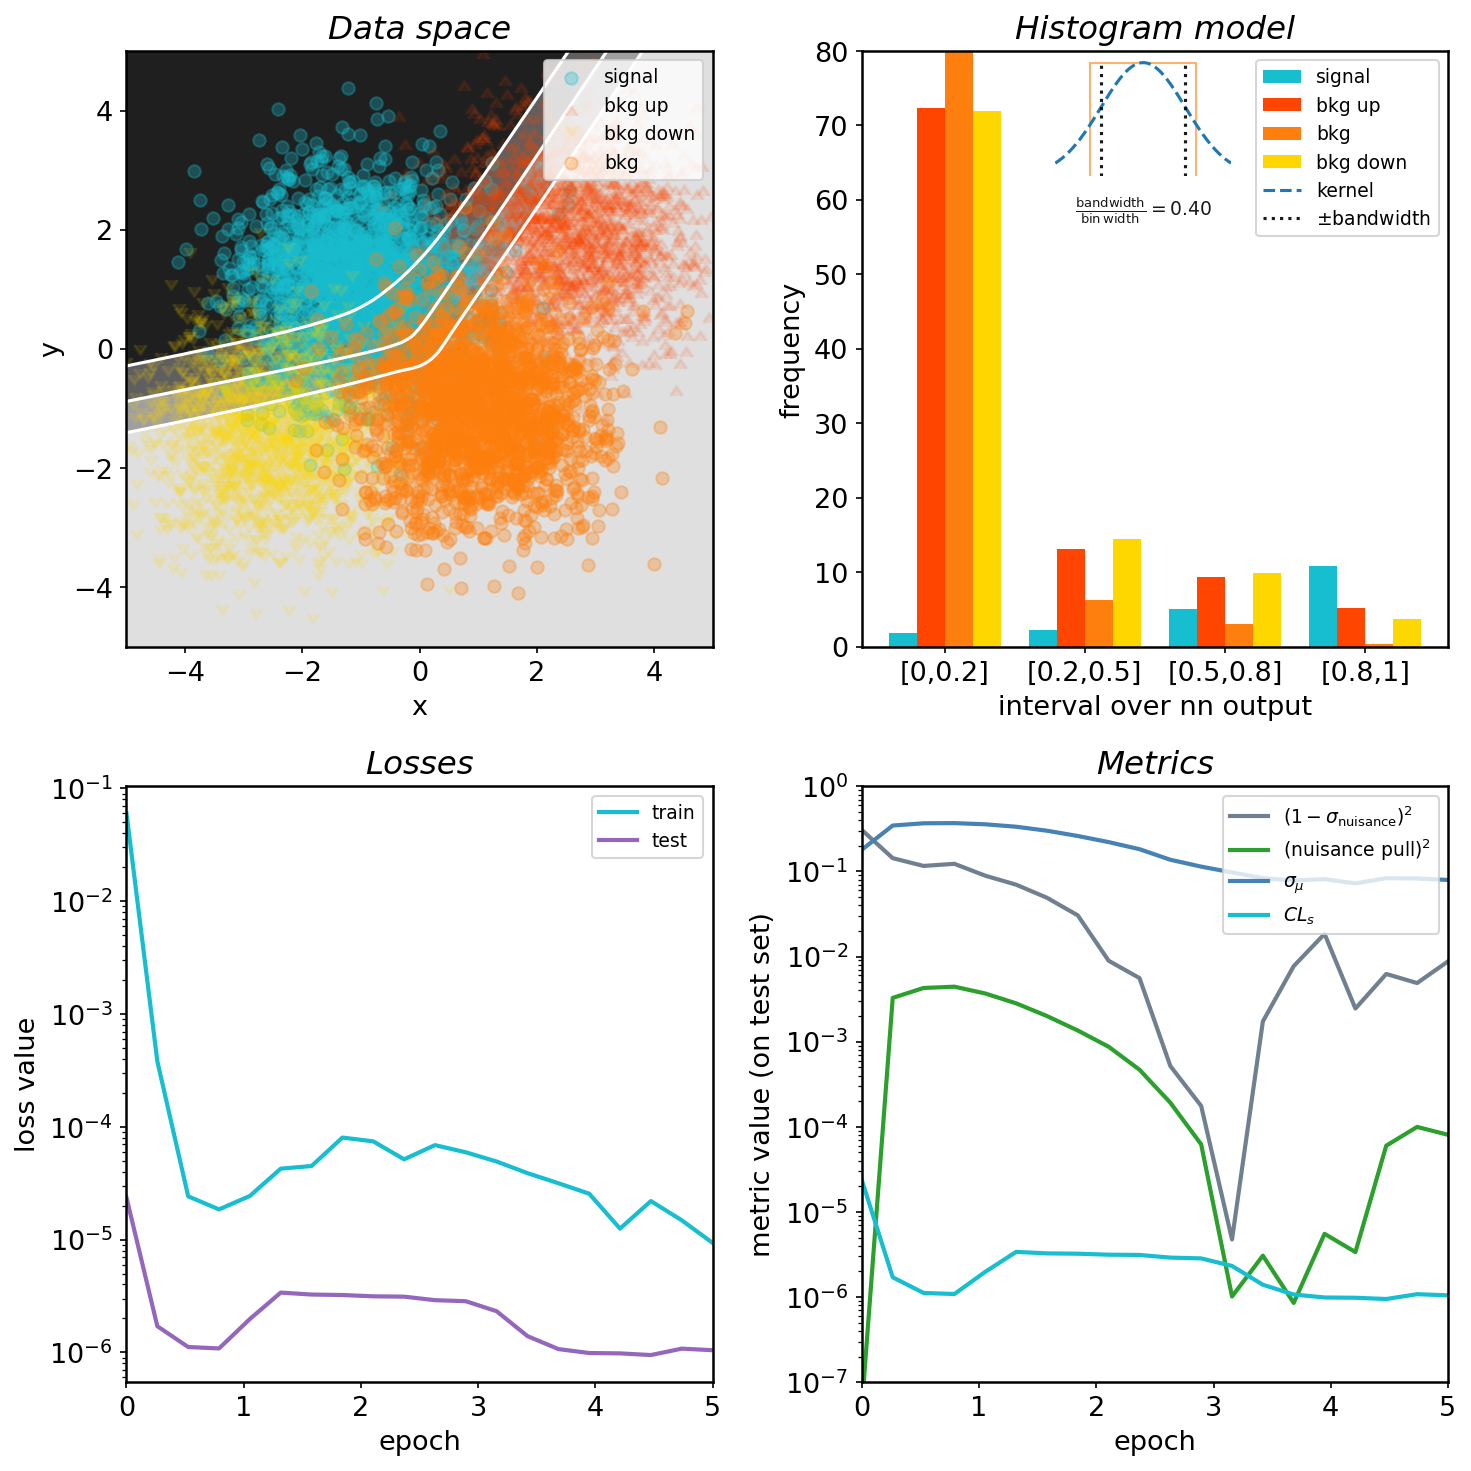

In [5]:
p.run()